In [2]:
from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt

#utility functions
def absPressure(p):
    return p + 14.75

def gaugePressure(p):
    return p - 14.75

def pascals(p):
    return p * 6895.

def psi(p):
    return p/6895.

# Analytical Model

/tmp/ipykernel_2593964/4110725796.py:27: RuntimeWarning: invalid value encountered in power
  return alpha*Pu * np.sqrt((Pd/Pu)**(2/k) - (Pd/Pu)**((k+1)/k))


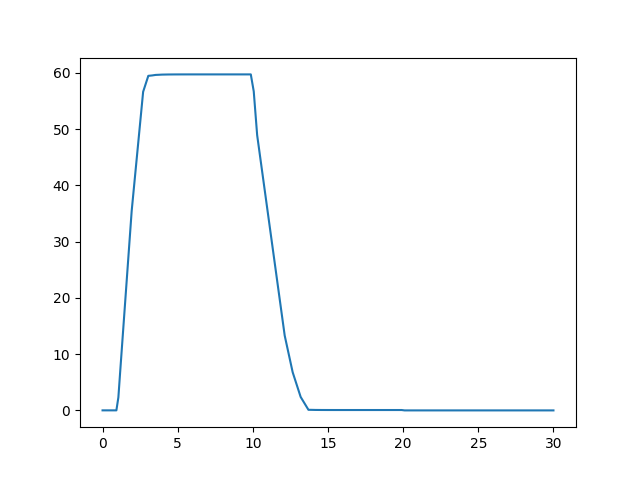

In [5]:


#physical constants
k = 1.4 
R = 8.31
T = 295.
V = .0004
M = .029
C_fill = 1
C_vent = 1
Z = 0.99
# theta = ((k+1)/2)**(k/(k-1))
theta = 1/0.3
Psrc = pascals(absPressure(60))
Patm = pascals(absPressure(0))


def calc_plant_derivs(t, p, calc_area):
    #constants, see appendix of Tassa paper 

    #NOTE: p comes in as absolute pressure


    #switching function for choked/unchoked flow
    def z(Pu, Pd):
        if Pu/Pd <= theta:
            # print('plant nonlinearity: ', np.sqrt((Pd/Pu)**(2/k) - (Pd/Pu)**((k+1)/k)))
            # print("UNCHOKED FLOW", Pu/Pd)
            return alpha*Pu * np.sqrt((Pd/Pu)**(2/k) - (Pd/Pu)**((k+1)/k))
        else:
            # print("CHOKED FLOW", Pu/Pd)
            return beta*Pu

    #switching function for direction of mass flow
    def phi(Pu,Pd):
        if Pu >= Pd:
            # print("FILL")
            return z(Pu,Pd)
        else:
            # print("VENT")
            return -z(Pd,Pu)

    a = calc_area(t)
    #valve cannot vent and fill at same time
    if a >= 0:
        #fill, from compressor to chamber
        alpha = C_fill * np.sqrt((2*M*k)/(Z*R*T*(k-1)))
        beta = C_fill * np.sqrt(((k*M)/(Z*R*T)) * (2/(k+1))**((k+1)/(k-1)))
        ac = a
        ar = 0
        mdot = ac*phi(Psrc, p)
    elif a < 0:
        #vent, from chamber to atm
        alpha = C_vent * np.sqrt((2*M*k)/(Z*R*T*(k-1)))
        beta = C_vent * np.sqrt(((k*M)/(Z*R*T)) * (2/(k+1))**((k+1)/(k-1)))
        ac = 0
        ar = np.abs(a) #positive area
        mdot = - ar*phi(p, Patm)

    pdot = k*R*T*mdot/V - 0 # zero for ignoring volume

    return pdot

def forward_sim_dt(x, u, dt, deriv_func):
    F1 = deriv_func(x, u)
    F2 = deriv_func(x + dt/2 * F1, u)
    F3 = deriv_func(x + dt/2 * F2, u)
    F4 = deriv_func(x + dt * F3, u)
    x += dt / 6 * (F1 + 2 * F2 + 2 * F3 + F4)

    return x

def calc_area(t):
    if t < 1:
        return 0
    elif t< 10:
        return 2.5e-5
    elif t< 20:
        return -2.5e-5
    else:
        return 0


%matplotlib widget
tspan = (0,30)
y0 = np.array([pascals(absPressure(0))])
sol  = solve_ivp(calc_plant_derivs, tspan, y0, max_step=5, args=(calc_area,))
plt.plot(sol.t, gaugePressure(psi(sol.y.flatten())))


In [1]:
import matplotlib.pyplot as plt
def simulate(C_fill, C_vent):
    #physical constants
    k = 1.4
    R = 8.31
    T = 295.
    V = .0004
    M = .029
    # C_fill = .7
    # C_vent = .7
    Z = 0.99
    theta = ((k+1)/2)**(k/(k-1))
    Psrc = pascals(absPressure(60))
    Patm = pascals(absPressure(0))
    def calc_plant_derivs(t, p, calc_area):
        #constants, see appendix of Tassa paper 

        #NOTE: p comes in as absolute pressure


        #switching function for choked/unchoked flow
        def z(Pu, Pd):
            if Pu/Pd <= theta:
                # print('plant nonlinearity: ', np.sqrt((Pd/Pu)**(2/k) - (Pd/Pu)**((k+1)/k)))
                # print("UNCHOKED FLOW", Pu/Pd)
                return alpha*Pu * np.sqrt((Pd/Pu)**(2/k) - (Pd/Pu)**((k+1)/k))
            else:
                # print("CHOKED FLOW", Pu/Pd)
                return beta*Pu

        #switching function for direction of mass flow
        def phi(Pu,Pd):
            if Pu >= Pd:
                # print("FILL")
                return z(Pu,Pd)
            else:
                # print("VENT")
                return -z(Pd,Pu)

        a = calc_area(t)
        #valve cannot vent and fill at same time
        if a >= 0:
            #fill, from compressor to chamber
            alpha = C_fill * np.sqrt((2*M*k)/(Z*R*T*(k-1)))
            beta = C_fill * np.sqrt(((k*M)/(Z*R*T)) * (2/(k+1))**((k+1)/(k-1)))
            ac = a
            ar = 0
            mdot = ac*phi(Psrc, p)
        elif a < 0:
            #vent, from chamber to atm
            alpha = C_vent * np.sqrt((2*M*k)/(Z*R*T*(k-1)))
            beta = C_vent * np.sqrt(((k*M)/(Z*R*T)) * (2/(k+1))**((k+1)/(k-1)))
            ac = 0
            ar = np.abs(a) #positive area
            mdot = - ar*phi(p, Patm)

        pdot = k*R*T*mdot/V - 0 # zero for ignoring volume
        return pdot

    def forward_sim_dt(x, u, dt, deriv_func):
        F1 = deriv_func(x, u)
        F2 = deriv_func(x + dt/2 * F1, u)
        F3 = deriv_func(x + dt/2 * F2, u)
        F4 = deriv_func(x + dt * F3, u)
        x += dt / 6 * (F1 + 2 * F2 + 2 * F3 + F4)

        return x

    def calc_area(t):
        if t < 1:
            return 0
        elif t< 10:
            return 2.5e-5
        elif t< 20:
            return -2.5e-5
        else:
            return 0


    tspan = (0,20)
    y0 = np.array([pascals(absPressure(0))])
    sol  = solve_ivp(calc_plant_derivs, tspan, y0, max_step=.01, args=(calc_area,))
    return sol

plt.figure(1)
plt.clf()
cfills = [.6,.7,.8,.9]
for i, cfill in enumerate(cfills):
    sol = simulate(cfill,.7)
    plt.plot(sol.t, gaugePressure(psi(sol.y.flatten())), label=f'Fill Coeff: {cfill}')

plt.legend()
plt.show()

plt.figure(2)
plt.clf()
cvents = [.6,.7,.8,.9]
for i, cvent in enumerate(cvents):
    sol = simulate(.7,cvent)
    plt.plot(sol.t, gaugePressure(psi(sol.y.flatten())), label=f'Vent Coeff: {cvent}')

plt.legend()
plt.show()

NameError: name 'pascals' is not defined

<Figure size 432x288 with 0 Axes>

# Gekko Model

Filling case:
$$ \dot{m} = a \phi(P_{src}, p) $$

$$ p_u = P_{src}, p_d = p$$

In [6]:
from gekko import GEKKO
import numpy as np

m = GEKKO()
tf = 10 #seconds, step data is 309 seconds
n = 101
m.time = np.linspace(0,tf, n)

#constants and parameters from papers
M = m.Const(.029) #gas molecular mass for air
Z = m.Const(0.99) #gas compressibility factor for air, dimensionless
R = m.Const(8.314472) # universal gas law constant
T = m.Param(295) #temp in Kelvin, 72 F
k = m.Const(1.4) #specific heat ratio for air
c = m.Param(0.72) #discharge coeff, often between .6 and .85 for orifice (https://en.wikipedia.org/wiki/Orifice_plate)
Psrc = m.Param(pascals(absPressure(60))) #same as 'upstream pressure' in paper
Patm = m.Param(pascals(absPressure(0))) #same as 'upstream pressure' in paper

V = m.Param(.0004) 

alpha = m.Intermediate(c * m.sqrt((2*M*k)/(Z*R*T*(k-1))))
beta = m.Intermediate(c * m.sqrt(((k*M)/(Z*R*T))*(2/(k+1))**((k+1)/(k-1))))
theta = m.Intermediate(((k+1)/2)**(k/(k-1)))

#dynamic variables m, pressure, volume (maybe ignore at first)
P = m.Var(pascals(absPressure(0)), lb=pascals(absPressure(0)), ub = pascals(absPressure(60)))
mass_flow = m.Var()

#manipulated variables: orifice area m^2
max_area = 2.5e-5 #25 mm^2 on large valve
a_des = np.ones(n) * max_area
a = m.MV(value = a_des)

#mass flow model
#choked and unchoked flow, filling and venting
#https://apmonitor.com/wiki/index.php/Main/ConditionalStatements
#conditional statements based on flow direction and condition
#except if3 is weird, its not really based on True/False...

#z function
f_fill_free = m.Intermediate(alpha*Psrc * m.sqrt((P/Psrc)**(2/k) - (P/Psrc)**((k+1)/k)))
f_fill_choked = m.Intermediate(beta*Psrc)

#flip psrc becomes p and p becomes patm because flow is opposite direction now
f_vent_free = m.Intermediate(alpha*P * m.sqrt((Patm/P)**(2/k) - (Patm/P)**((k+1)/k)))
f_vent_choked = m.Intermediate(beta*P)

f_fill = m.if3(theta - Psrc/P, f_fill_choked, f_fill_free)
f_vent = m.if3(theta - P/Psrc, f_vent_choked, f_vent_free)

#mass flow, phi function
m.Equation(mass_flow.dt() == m.if3(P - Psrc,a*f_fill, -a*f_vent))

#chamber pressure model, 0 is for volume term
m.Equation(P.dt() == k*R*T*mass_flow.dt()/V - 0)

m.options.IMODE = 4 #simulation

m.solve()


apm 10.32.114.116_gk_model4 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            4
   Variables    :           20
   Intermediates:            7
   Connections  :            0
   Equations    :           18
   Residuals    :           11
 
 Number of state variables:           1700
 Number of total equations: -         1300
 Number of slack variables: -          600
 ---------------------------------------
 Degrees of freedom       :           -200
 
 @error: Degrees of Freedom
 * Error: DOF must be zero for this mode
 STOPPING...


Exception:  @error: Degrees of Freedom
 * Error: DOF must be zero for this mode
 STOPPING...


# Just Filling Gekko Model

In [46]:
##TRYING JUST FILLING DYNAMICS FOR NOW. CAN'T GET OTHER MODEL TO WORK WITH BOTH.

from gekko import GEKKO
import numpy as np

m = GEKKO()
tf = 10 #seconds, step data is 309 seconds
n = 101
m.time = np.linspace(0,tf, n)

#constants and parameters from papers
M = m.Const(.029) #gas molecular mass for air
Z = m.Const(0.99) #gas compressibility factor for air, dimensionless
R = m.Const(8.314472) # universal gas law constant
T = m.Param(295) #temp in Kelvin, 72 F
k = m.Const(1.4) #specific heat ratio for air
c = m.Param(0.72) #discharge coeff, often between .6 and .85 for orifice (https://en.wikipedia.org/wiki/Orifice_plate)
Psrc = pascals(absPressure(60))
Psrc = m.Param(Psrc)

V = m.Param(.0004) 

alpha = m.Intermediate(c * m.sqrt((2*M*k)/(Z*R*T*(k-1))))
beta = m.Intermediate(c * m.sqrt(((k*M)/(Z*R*T))*(2/(k+1))**((k+1)/(k-1))))
theta = m.Intermediate(((k+1)/2)**(k/(k-1)))

#dynamic variables m, pressure, volume (maybe ignore at first)
P = m.Var()

#manipulated variables: orifice area m^2
max_area = 2.5e-5 #25 mm^2 on large valve
a_des = np.ones(n) * max_area
a = m.Param(value = a_des)

#mass flow model
#choked and unchoked flow, filling and venting
#https://apmonitor.com/wiki/index.php/Main/ConditionalStatements
#conditional statements based on flow direction and condition
#except if3 is weird, its not really based on True/False...

#z function
f_fill_free = m.Intermediate(alpha*Psrc * m.sqrt((P/Psrc)**(2/k) - (P/Psrc)**((k+1)/k)))
f_fill_choked = m.Intermediate(beta*Psrc)



f_fill = m.if2(theta - Psrc/P, f_fill_choked, f_fill_free)

#this one works all the time, but is nonsense.
# f_fill = m.Intermediate(beta*Psrc)

#this work when P is not given initial value
# f_fill = m.Intermediate(alpha*Psrc * m.sqrt((P/Psrc)**(2/k) - (P/Psrc)**((k+1)/k)))

#mass flow, phi function
mass_flow_rate = m.Intermediate(a*f_fill)

#chamber pressure model, 0 is for volume term
m.Equation(P.dt() == k*R*T*mass_flow_rate/V - 0)

m.options.NODES = 6
m.options.IMODE = 4 #simulation

m.solve()


apm 10.32.114.116_gk_model28 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            1
   Constants    :            4
   Variables    :           10
   Intermediates:            6
   Connections  :            2
   Equations    :           10
   Residuals    :            4
 
 Number of state variables:           4000
 Number of total equations: -         3000
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :           1000
 
 @error: Degrees of Freedom
 * Error: DOF must be zero for this mode
 STOPPING...


Exception:  @error: Degrees of Freedom
 * Error: DOF must be zero for this mode
 STOPPING...


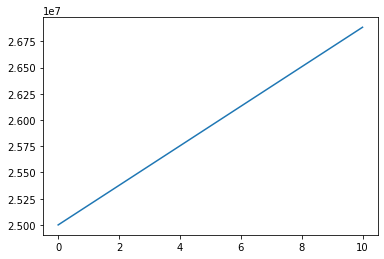

In [45]:
import matplotlib.pyplot as plt
plt.plot(m.time, P)